### Importando bibliotecas e o Dataframe

In [108]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

In [109]:
df = pd.read_csv("../dados/plataforma.csv")

In [110]:
df.shape

(7, 27)

### Dataframe original

In [111]:
df_original = pd.read_csv("../dados/plataforma_original.csv")

In [112]:
df_original.shape

(7, 28)

### Configurando alguns padrões de exibição do Pandas

In [113]:
pd.set_option('display.max_columns', None)

Exibição do dataframe não irá ocultar nenhuma coluna mais!

In [114]:
pd.options.display.float_format = '{:.5f}'.format

Ajustando a quantidade de números após a vírgula de um valor ponto flutuante a fim de evitar as notações cientificas em campos desnecessário, como o indentificador da plataforma que é um número inteiro!

### Analisando o DataFrame

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 27 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   platform                                          7 non-null      int64  
 1   water_depth                                       7 non-null      int64  
 2   weight                                            7 non-null      int64  
 3   installation_date                                 7 non-null      int64  
 4   type_of_production (1 oil and gas; 2 oil; 3 gas)  7 non-null      int64  
 5   number_of_legs                                    7 non-null      int64  
 6   number_of_piles                                   7 non-null      int64  
 7   height_of_jacket_or_sub-structure                 7 non-null      float64
 8   distance_to_coast                                 7 non-null      int64  
 9   risk_to_other_users-compl

**OBS:** Nenhum valor nulo ou valores faltantes foi observado e apenas a coluna 27 é string, as demais colunas são compostas por inteiros ou ponto flutuante. 

**OBS²:** O dataframe `plataforma.csv` agora tem 26 colunas, a última coluna que era uma string foi removida.

**OBS³:** O dataframe `plataforma_original.csv` permanece com as 27 colunas originais.

In [116]:
df.groupby(['type_of_production (1 oil and gas; 2 oil; 3 gas)']).size()

type_of_production (1 oil and gas; 2 oil; 3 gas)
1    3
2    2
3    2
dtype: int64

In [117]:
df_2 = df.select_dtypes([int, float])
df_2.std()

platform                                               11.98412
water_depth                                            22.30738
weight                                               7027.96876
installation_date                                       5.03322
type_of_production (1 oil and gas; 2 oil; 3 gas)        0.89974
number_of_legs                                          1.51186
number_of_piles                                        10.10657
height_of_jacket_or_sub-structure                      18.99342
distance_to_coast                                      58.79302
risk_to_other_users-complete                            0.53452
risk_to_other_users-partial                             0.00001
risk_to_personnel-complete                              0.11549
risk_to_personnel-partial                               0.05678
energy_consumption-complete                        339364.74561
energy_consumption-partial                         170536.41756
emissions-complete                      

**Nota:** colunas `total_removal_cost-complete` e `impacts_of_option-partial` não possuem desvio padrão, sendo irrelevantes para nosso DataFrame. Adicionalmente, a coluna `risk_to_other_users-partial` possue o desvio padrão muito baixa. 

In [118]:
df_std_zero = df_2.loc[:, df_2.std() == 0]
df_std_zero.head()

,impacts_of_option-partial,total_removal_cost-complete
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


#### Remoção dos dados irrelevantes

In [119]:
df.shape

(7, 27)

In [120]:
colunas_para_dropar = ['total_removal_cost-complete', 'impacts_of_option-partial', 'risk_to_other_users-partial']

In [121]:
df[colunas_para_dropar]

,total_removal_cost-complete,impacts_of_option-partial,risk_to_other_users-partial
0,1,1,0.00000
1,1,1,0.00000
2,1,1,0.00003
3,1,1,0.00002
4,1,1,0.00000
5,1,1,0.00001
6,1,1,0.00000


In [122]:
df.drop(colunas_para_dropar, axis=1, inplace=True)

In [123]:
df.shape

(7, 24)

#### Mapa de correlação das características das plataformas

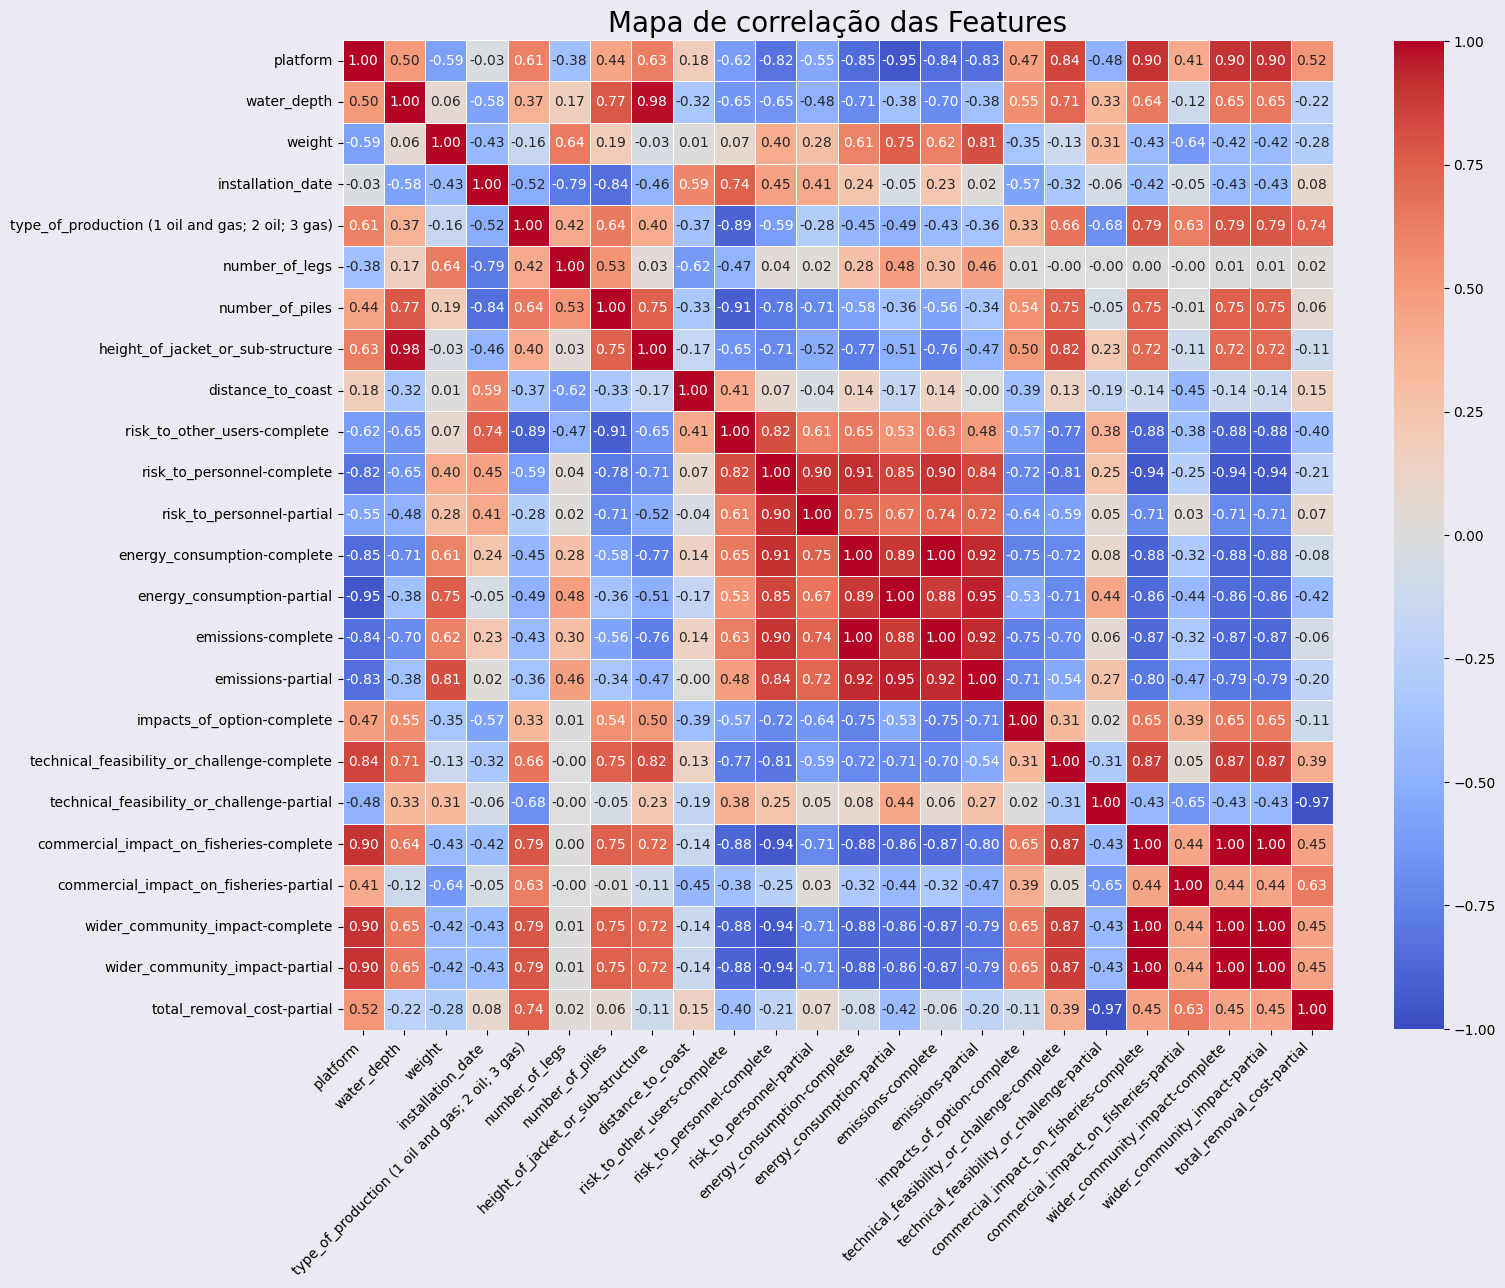

In [124]:
matriz_correlacao = df.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de correlação das Features', fontsize=20)

plt.tight_layout()

plt.show()

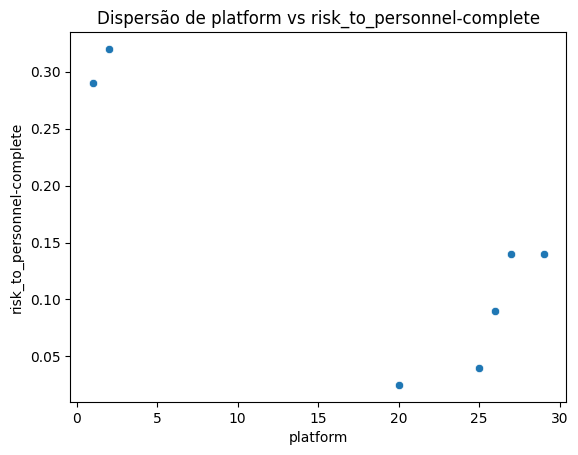

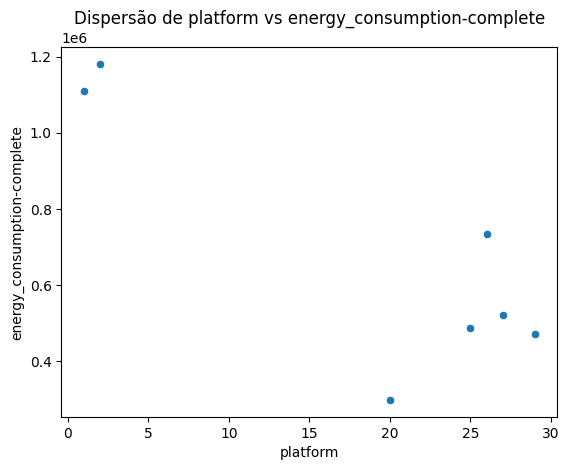

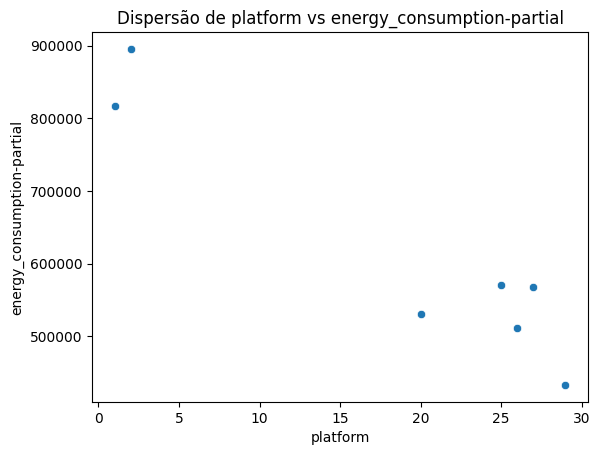

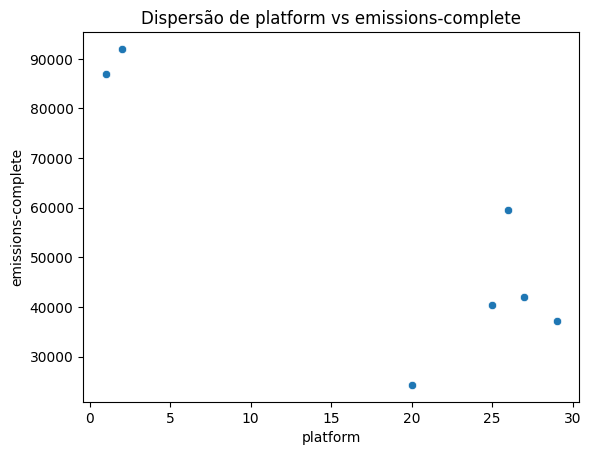

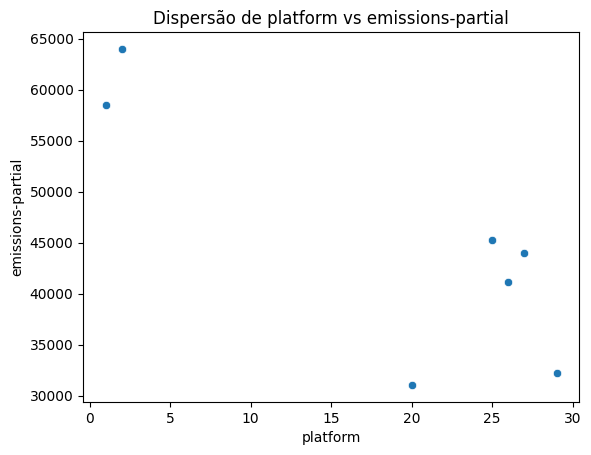

In [125]:
# Variáveis com alta correlação com outras variáveis
alta_correlacao = matriz_correlacao[abs(matriz_correlacao) > 0.7].stack().index.tolist()

# Remover as correlações iguais a 1 (correlações de uma variável com ela mesma)
alta_correlacao = [(v1, v2) for v1, v2 in alta_correlacao if v1 != v2]

numero_de_pares = 5
pares_selecionados = alta_correlacao[:numero_de_pares]

# Plotando o gráfico de dispersão
for v1, v2 in pares_selecionados:
    sns.scatterplot(x=df[v1], y=df[v2])
    plt.xlabel(v1)
    plt.ylabel(v2)

    plt.title(f"Dispersão de {v1} vs {v2}")

    plt.show()

### Padronizando os valores do DataFrame

In [126]:
from sklearn.preprocessing import StandardScaler

In [127]:
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(df)

### Aplicando o Kmeans

In [128]:
# Ajuste do PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(dados_padronizados)

In [129]:
# Ajuste do KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
rotulos_kmeans = kmeans.labels_

/home/bruno/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [130]:
rotulos_kmeans

array([1, 1, 0, 0, 0, 0, 0], dtype=int32)

In [131]:
# Adicionando os clusters de cada plataforma como uma coluna no DataFrame
df['cluster'] = rotulos_kmeans

In [132]:
df

,platform,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete,energy_consumption-partial,emissions-complete,emissions-partial,impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-partial,cluster
0,1,99,22000,1988,1,8,8,114.00000,187,1,0.29000,0.12000,1110100,817000,87000,58500,0.43000,0.00000,1.00000,0.79000,0.78000,0.50000,0.50000,0.56000,1
1,2,112,30364,1983,1,8,9,123.00000,207,1,0.32000,0.16000,1180500,895500,92000,64000,0.51000,0.00000,1.00000,0.79000,0.78000,0.50000,0.50000,0.56000,1
2,20,141,15561,1978,2,8,26,147.00000,120,0,0.02500,0.01000,297654,530148,24277,31064,0.66000,0.25000,1.00000,1.00000,0.94000,1.00000,1.00000,0.54000,0
3,25,156,27647,1980,2,8,32,166.00000,240,0,0.04000,0.02000,487750,570818,40416,45266,0.53000,0.64000,1.00000,1.00000,0.66000,1.00000,1.00000,0.57000,0
4,26,103,18584,1983,3,8,20,122.50000,230,0,0.09000,0.06000,733082,511765,59588,41170,0.53000,0.39000,0.15000,1.00000,0.99000,1.00000,1.00000,0.73000,0
5,27,144,17500,1983,3,8,20,154.00000,130,0,0.14000,0.13000,520000,568000,42000,44000,0.53000,0.45000,0.70000,1.00000,1.00000,1.00000,1.00000,0.66000,0
6,29,116,10054,1993,1,4,5,136.00000,282,1,0.14000,0.08000,469823,433179,37162,32191,0.53000,0.29000,0.81000,0.93000,0.86000,0.83000,0.83000,0.60000,0


In [133]:
# Criando um gráfico para analisar os clusters das plataformas
info_plataformas = ['platform', 'water_depth', 'type_of_production (1 oil and gas; 2 oil; 3 gas)', 'number_of_piles']

colors = ['red', 'blue']

grafico_kmeans = px.scatter(df, x=X_pca[:, 0], y=X_pca[:, 1], color='cluster', hover_data=info_plataformas, color_continuous_scale=colors)

grafico_kmeans.show()

### Criando novos registros

In [134]:
df.drop(['cluster'], axis=1, inplace=True)

In [135]:
df.head()

,platform,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete,energy_consumption-partial,emissions-complete,emissions-partial,impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-partial
0,1,99,22000,1988,1,8,8,114.00000,187,1,0.29000,0.12000,1110100,817000,87000,58500,0.43000,0.00000,1.00000,0.79000,0.78000,0.50000,0.50000,0.56000
1,2,112,30364,1983,1,8,9,123.00000,207,1,0.32000,0.16000,1180500,895500,92000,64000,0.51000,0.00000,1.00000,0.79000,0.78000,0.50000,0.50000,0.56000
2,20,141,15561,1978,2,8,26,147.00000,120,0,0.02500,0.01000,297654,530148,24277,31064,0.66000,0.25000,1.00000,1.00000,0.94000,1.00000,1.00000,0.54000
3,25,156,27647,1980,2,8,32,166.00000,240,0,0.04000,0.02000,487750,570818,40416,45266,0.53000,0.64000,1.00000,1.00000,0.66000,1.00000,1.00000,0.57000
4,26,103,18584,1983,3,8,20,122.50000,230,0,0.09000,0.06000,733082,511765,59588,41170,0.53000,0.39000,0.15000,1.00000,0.99000,1.00000,1.00000,0.73000


In [136]:
df.shape

(7, 24)

In [137]:
# Função para adicionar ruído a um registro
def gerar_ruido_registro(registro, amplitude_ruido_int=2, amplitude_ruido_float=0.2):
    registro_com_ruido = registro.copy() # Copiando o registro alvo
    for coluna, valor in registro_com_ruido.items(): # Percorrendo os valores do registro
        if int(valor) == valor: # Verificando se é inteiro (está sendo tratado desta forma por conta do iloc que retorna valores como 1.00)
            ruido_int = np.random.randint(-amplitude_ruido_int, amplitude_ruido_int + 1)

            if valor + ruido_int < 0:
                ruido_int = -valor  # Garante que o ruído resultante não faça o valor ser negativo
            
            registro_com_ruido[coluna] += ruido_int
        else:
            ruido_float = np.random.normal(scale=amplitude_ruido_float)

            if valor + ruido_float < 0:
                ruido_int = -valor  # Garante que o ruído resultante não faça o valor ser negativo

            registro_com_ruido[coluna] += ruido_float
    return registro_com_ruido

In [138]:
# Exemplo de um registro
registro = {'coluna_inteira': 10, 'coluna_float': 3.14}

# Adiciona ruído ao registro
registro_com_ruido = gerar_ruido_registro(registro)

# Exibindo o registro com ruído
print("Registro original:", registro)
print("Registro com ruído:", registro_com_ruido)

Registro original: {'coluna_inteira': 10, 'coluna_float': 3.14}
Registro com ruído: {'coluna_inteira': 9, 'coluna_float': 3.180165797002082}


#### Criando um novo dataframe de instâncias artificiais com ruído

#### Primeira versão

In [139]:
df_2 = df.copy()

In [140]:
# Inicializando uma lista para armazenar os novos registros
novos_registros = []

# Laço irá rodar até que o DataFrame tenha 1000 registros
for _ in range(100):
    # Escolhendo aleatoriamente um dos registros existentes
    indice_registro = np.random.randint(0, len(df_2))
    registro_selecionado = df_2.iloc[indice_registro]
    
    # Aplicar a função de ruído ao registro selecionado e adicionar à lista
    novo_registro = gerar_ruido_registro(registro_selecionado)
    novos_registros.append(novo_registro)

# Concatenar os novos registros com o DataFrame original
df_3 = pd.concat([df, pd.DataFrame(novos_registros)], ignore_index=True)

In [141]:
df_2.shape, df_3.shape

((7, 24), (107, 24))

In [142]:
# Inicializando uma lista para armazenar os novos registros
novos_registros = []

# Laço irá rodar até que o DataFrame tenha 1000 registros
for _ in range(900):
    # Escolhendo aleatoriamente um dos registros existentes
    indice_registro = np.random.randint(0, len(df_3))
    registro_selecionado = df_3.iloc[indice_registro]
    
    # Aplicar a função de ruído ao registro selecionado e adicionar à lista
    novo_registro = gerar_ruido_registro(registro_selecionado)
    novos_registros.append(novo_registro)

# Concatenar os novos registros com o DataFrame original
df_4 = pd.concat([df_3, pd.DataFrame(novos_registros)], ignore_index=True)

In [143]:
df_3.shape, df_4.shape

((107, 24), (1007, 24))

#### Segunda versão

In [ ]:
# As primeiras 7 instâncias originais
instancias_originais = df.iloc[:7]

# Criando 100 novas instâncias com base nas 7 originais
novas_100_instancias = []
for _ in range(100):
    for _, registro in instancias_originais.iterrows():
        registro_com_ruido = gerar_ruido_registro(registro)
        novas_100_instancias.append(registro_com_ruido)

# Criando 900 novas instâncias com base nas 100 artificiais criadas
novas_900_instancias = []
for _ in range(900):
    for registro in novas_100_instancias[7:]: # Usando apenas as primeiras 7 instâncias com ruído
        registro_com_ruido = gerar_ruido_registro(registro)
        novas_900_instancias.append(registro_com_ruido)

# Convertendo para dataframe
df_instancias_originais = pd.DataFrame(instancias_originais)
df_novas_100_instancias = pd.DataFrame(novas_100_instancias)
df_novas_900_instancias = pd.DataFrame(novas_900_instancias)

# Concatenando os dataframes
df_ruido = pd.concat([df_instancias_originais, df_novas_100_instancias, df_novas_900_instancias], ignore_index=True)

# Limitando a 1000 novas instâncias
df_ruido = df_ruido.head(1000)

df_ruido.to_csv("../dados/registros_com_ruido.csv", index=False)

In [ ]:
df_ruido = pd.read_csv("../dados/registros_com_ruido.csv")

In [ ]:
df_ruido.shape

(1000, 24)

In [ ]:
df.shape

(7, 24)

#### Aplicando o K-means no dataframe com ruído

In [ ]:
dados_padronizados_ruido = scaler.fit_transform(df_ruido)

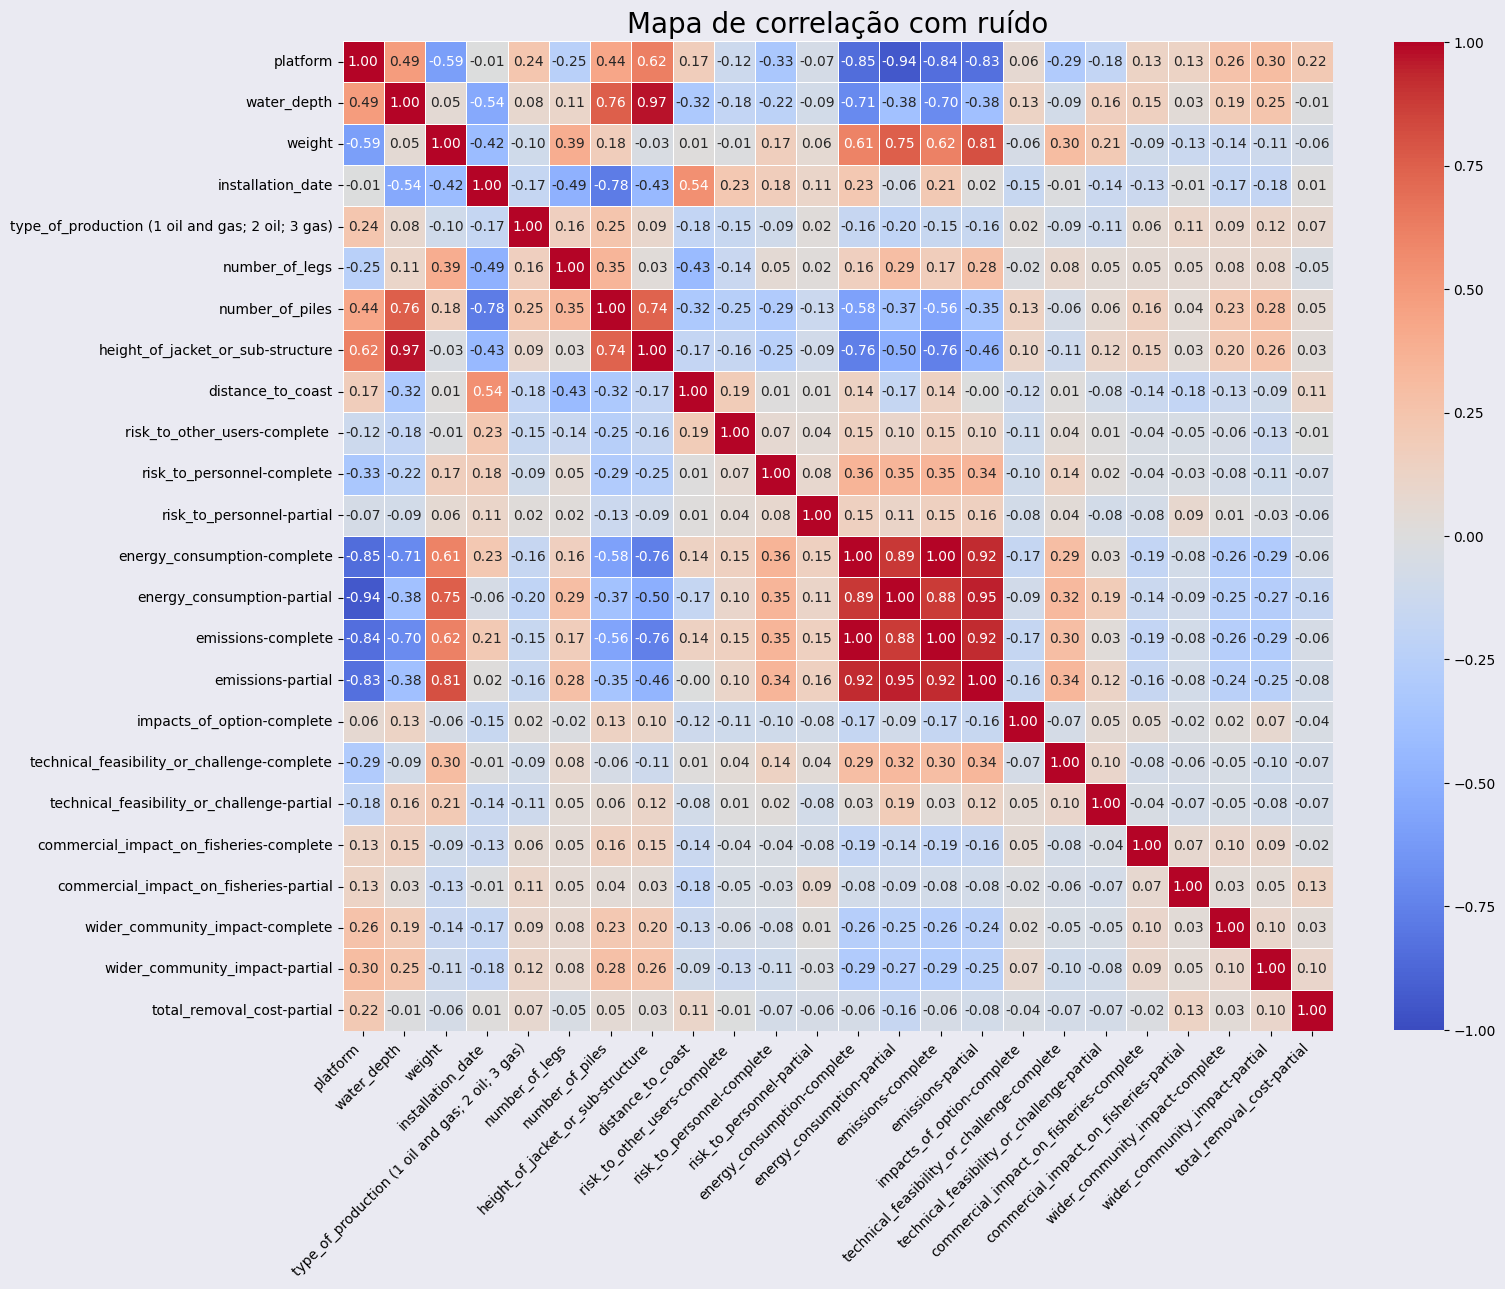

In [ ]:
matriz_correlacao_ruido = df_ruido.corr()

# Plotando da mesma forma que no dataframe original
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao_ruido,
                xticklabels=df_ruido.columns,
                yticklabels=df_ruido.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Mapa de correlação com ruído', fontsize=20)

plt.tight_layout()

plt.show()

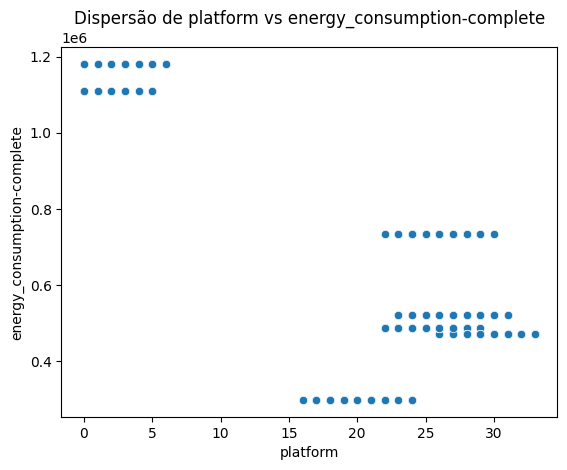

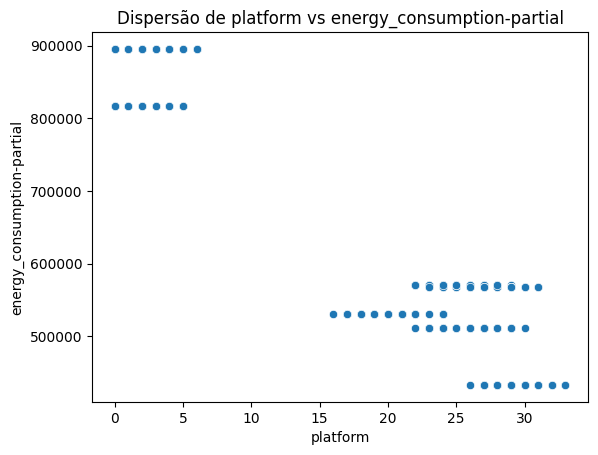

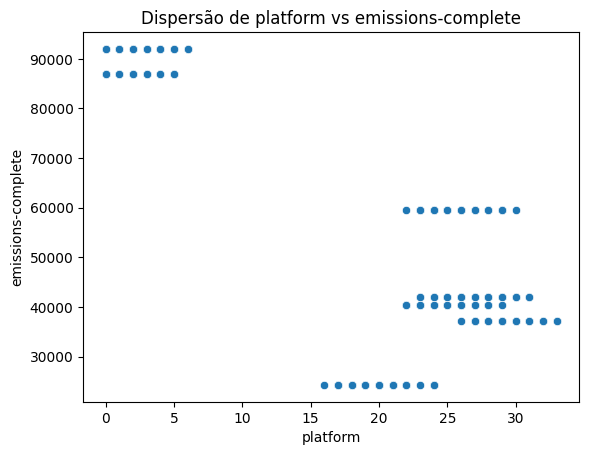

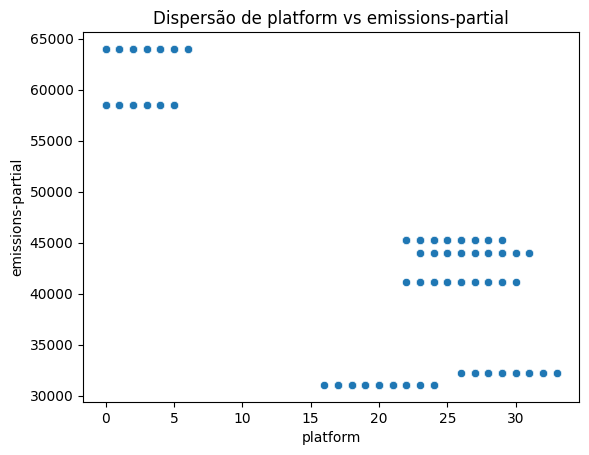

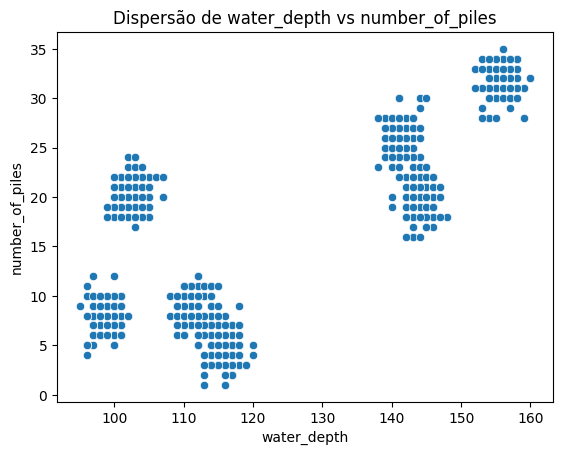

In [ ]:
# Selecionando as variáveis com alta correlação com outras variáveis
alta_correlacao = matriz_correlacao_ruido[abs(matriz_correlacao_ruido) > 0.7].stack().index.tolist()

# Removendo as correlações de uma variável com ela mesma
alta_correlacao = [(i, j) for i, j in alta_correlacao if i != j]

# Limitando aos primeiros 5 gráficos de dispersão
numero_de_pares = 5
pares_selecionados = alta_correlacao[:numero_de_pares]

# Plotando o gráfico de dispersão
for i, j in pares_selecionados:
    sns.scatterplot(x=df_ruido[i], y=df_ruido[j])
    plt.xlabel(i)
    plt.ylabel(j)
    plt.title(f"Dispersão de {i} vs {j}")
    plt.show()

In [ ]:
pca_ruido = PCA(n_components=2)
df_pca_ruido = pca_ruido.fit_transform(dados_padronizados_ruido)

kmeans_ruido = KMeans(n_clusters=2)
kmeans_ruido.fit(dados_padronizados_ruido)

df_ruido['cluster'] = kmeans_ruido.labels_


/home/carlos/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
info_plataformas = ['platform', 'water_depth', 'type_of_production (1 oil and gas; 2 oil; 3 gas)', 'number_of_piles']

colors = ['red', 'blue']

grafico_kmeans = px.scatter(df_ruido, x=df_pca_ruido[:, 0], y=df_pca_ruido[:, 1], color='cluster', hover_data=info_plataformas, color_continuous_scale=colors)

grafico_kmeans.show()